<a href="https://colab.research.google.com/github/pmilks/cap-comp215/blob/main/Project%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import json, requests
from math import ceil
from google.colab import output

def MergeDic(dic1,dic2):
  new_dic = {}
  for k,v in dic1.items():
    new_dic[k] = v
  for k,v in dic2.items():
    new_dic[k] = v
  return new_dic

class Flight:
  def __init__(self, f_number, airline, departure, arrival, f_date):
      self.f_number = f_number
      self.airline = airline
      self.departure = departure
      self.arrival = arrival
      self.f_date = f_date

  def __str__(self):
      return f"Flight {self.f_number} from {self.departure} to {self.arrival} via {self.airline} airline on {self.f_date}."
   
  @classmethod
  def NewFlight(cls, flight):
      return Flight(flight['flight']['icao'],
                    flight['airline']['icao'],
                    flight['departure']['icao'],
                    flight['arrival']['icao'],
                    flight['flight_date'])
#Incoming flights/country
def IncomingCount(arrivals):
  countries = {}
  for airport in list(arrivals.keys()):
    if airport_codes[airport][3] in countries:
      countries[airport_codes[airport][3]] += 1
    else:
      countries[airport_codes[airport][3]] = 1
  return countries

#Departing flights/country
def OutgoingCount(departures):
  countries = {}
  #skip coordinates from grid
  for airport in list(departures.keys())[4:]:
    if airport_codes[airport][3] in countries:
      countries[airport_codes[airport][3]] += 1
    else:
      countries[airport_codes[airport][3]] = 1
  return countries

#Airline Count
def AirlineCount(all_flights):
  all_airlines = [flight.airline for flight in all_flights]
  airlines = {}
  for airline in all_airlines:
    if airline in airlines:
      airlines[airline] += 1
    else:
      airlines[airline] = 1
  return airlines

Choose the number of flights to display (10-100): 25
0 flights could not be processed.
Would you like a global or centralized view of your flights?
g for global, c for centralized: c


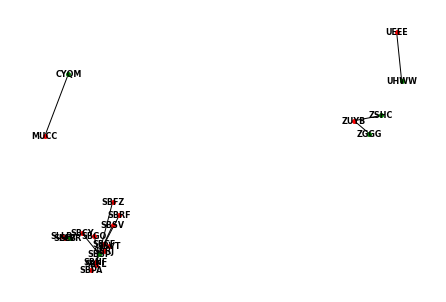

In [10]:
limit = input("Choose the number of flights to display (10-100): ")

# fl = open('10 flights.txt','r')
# flights = json.loads(fl.read())['data']
# fl.close()
params = {
  'access_key': '6fecf1f08ce3c5470b929c45e9232bfa',
  'limit': limit
}
response = requests.get('http://api.aviationstack.com/v1/flights', params)
flights = json.loads(response.text)['data']
ar = open('airport codes.txt','r')
airport_codes = json.loads(ar.read())['icaos']
ar.close()

all_flights = [Flight.NewFlight(flight) for flight in flights if flight['departure']['icao'] in airport_codes and flight['arrival']['icao'] in airport_codes]
if len(all_flights) != limit:
  print(f"{int(limit)-len(all_flights)} flights could not be processed.")

departures = {}
if input("Would you like a global or centralized view of your flights?\ng for global, c for centralized: ") == 'g':
  departures ={'NW':(-180,90),
                'SW':(-180,-90),
                'NE':(180,90),
                'SE':(180,-90)}

arrivals = {}
connections = []
for flight in all_flights:
  departures[flight.departure] = (int(float(airport_codes[flight.departure][6])),
                                            int(float(airport_codes[flight.departure][5])))
  arrivals[flight.arrival] = (int(float(airport_codes[flight.arrival][6])),
                                            int(float(airport_codes[flight.arrival][5])))
  connections.append((flight.departure,flight.arrival))

dep_arr_pos = MergeDic(departures,arrivals)
flight_plan = nx.Graph()
flight_plan.add_nodes_from(list(dep_arr_pos))
flight_plan.add_edges_from(connections)
nx.draw(flight_plan,dep_arr_pos,with_labels=True,node_size=0,font_size=8,font_weight='bold')
nx.draw_networkx_nodes(flight_plan, departures,nodelist=departures,node_color='green', node_size=15)
nx.draw_networkx_nodes(flight_plan, arrivals,nodelist=arrivals,node_color='red', node_size=15)

In [11]:
page = 1
max_selec = 10
max_page = ceil(len(all_flights)/10)
while(True):
  print(f"Here is a selection of flights [{page*10-9}-{max_selec} of {len(all_flights)}]")
  for i in range(page*10-10,max_selec):
    print(all_flights[i])
  input("Enter any key to go to next page.")
  if page == max_page-1:
      page += 1
      max_selec = len(all_flights)
  elif page == max_page:
      page = 1
      max_selec = 10
  else:
      page += 1
      max_selec += 10
  output.clear()

Here is a selection of flights [1-10 of 25]
Flight SWG238 from CYQM to MUCC via SWG airline on 2023-03-04.
Flight GLO1202 from SBSP to SBPA via GLO airline on 2023-03-04.
Flight LAN3156 from SBSP to SBSV via LAN airline on 2023-03-04.
Flight AZU4200 from SBSP to SBRF via AZU airline on 2023-03-04.
Flight GLO1562 from SBSP to SBFZ via GLO airline on 2023-03-04.
Flight LAN3042 from SBSP to SBFL via LAN airline on 2023-03-04.
Flight LAN3112 from SBSP to SBGO via LAN airline on 2023-03-04.
Flight LAN3900 from SBSP to SBRJ via LAN airline on 2023-03-04.
Flight LAN3166 from SBSP to SBCY via LAN airline on 2023-03-04.
Flight AZU2606 from SBSP to SBRJ via AZU airline on 2023-03-04.


KeyboardInterrupt: ignored

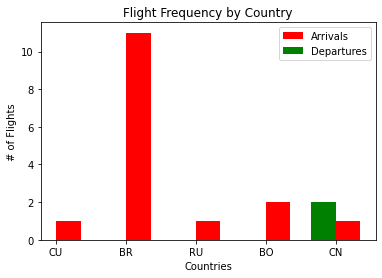

In [12]:
#Fix y-tick intervals
width = 0.35
arr_graph = plt.bar(IncomingCount(arrivals).keys(), IncomingCount(arrivals).values(),align='edge',color='r',width=+width,label='Arrivals')
dep_graph = plt.bar(OutgoingCount(departures).keys(), OutgoingCount(departures).values(),align='edge',color='g',width=-width,label='Departures')
plt.xlabel('Countries')
plt.ylabel('# of Flights')
plt.title('Flight Frequency by Country')
plt.legend()

Text(0.5, 1.0, 'Flight Frequency by Airline')

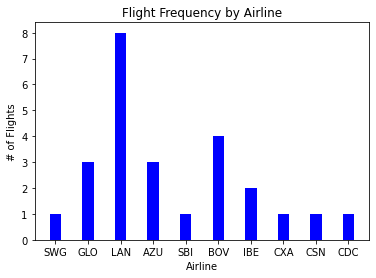

In [13]:
airl_graph = plt.bar(AirlineCount(all_flights).keys(), AirlineCount(all_flights).values(), width, color='blue')
plt.xlabel('Airline')
plt.ylabel('# of Flights')
plt.title('Flight Frequency by Airline')

In [ ]:
#FindICAOs
#Define ICAO
def SearchICAO():
  unk_icao = input("Enter airport ICAO: ")
  if len(unk_icao) == 4:
    if unk_icao in airport_codes:
      print(f"{unk_icao} is {airport_codes[unk_icao][0]} in {airport_codes[unk_icao][1]}, {airport_codes[unk_icao][2]}, {airport_codes[unk_icao][3]}.")
    else:
      print("Sorry that icao couldn't be identified.")

def SearchDeparting():
  loc = input("Search for flights departing from (State/Province, Country): ")
  valid_dep = set()
  for connection in connections:
    if airport_codes[connection[0]][3] == loc.split(', ')[1] and airport_codes[connection[0]][2] == loc.split(', ')[0]:
      valid_dep.add(connection)
  if not valid_dep:
    print(f"There are no flights departing from {loc}.")
  else:
    for connection in valid_dep:
      for flight in all_flights:
        if flight.departure == connection[0] and flight.arrival == connection[1]:
          print(f"{flight.f_number} departs from {loc} to {flight.arrival}.")

def SearchArriving():
  loc = input("Search for flights arriving to (State/Province, Country): ")
  valid_arr = set()
  for connection in connections:
    if airport_codes[connection[1]][3] == loc.split(', ')[1] and airport_codes[connection[1]][2] == loc.split(', ')[0]:
      valid_arr.add(connection)
  if not valid_arr:
    print(f"There are no flights arriving to {loc}.")
  else:
    for connection in valid_arr:
      for flight in all_flights:
        if flight.departure == connection[0] and flight.arrival == connection[1]:
          print(f"{flight.f_number} arrives at {loc} from {flight.departure}.")

def SearchFlightNumber():
  unk_num = input("Enter a flight number: ")
  for flight in all_flights:
    if flight.f_number == unk_num:
      print(flight)
      return
    else:
      print("No matching flight number was found.")

while(True):
  menu = int(input("Would you to\n1) Search an ICAO\n2) Search flights by departure\n3) Seach flights by arrival\n4) Search by flight number\n\nSelect 1-4: "))
  if menu == 1:
    SearchICAO()
  elif menu == 2:
    SearchDeparting()
  elif menu == 3:
    SearchArriving()
  elif menu == 4:
    SearchFlightNumber()
  input("Enter any key to search something new.")
  output.clear()

Would you to
1) Search an ICAO
2) Search flights by departure
3) Seach flights by arrival
4) Search by flight number

Select 1-4: 1
Enter airport ICAO: CYQM
CYQM is Greater Moncton International Airport in Moncton, New Brunswick, CA.
